In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix


#### Saving or loading the model as desired.

In [8]:
from tensorflow.keras.models import load_model

In [50]:
#model.save("model_5") creates a folder with the same name as the model

INFO:tensorflow:Assets written to: model_5\assets


In [9]:
model = load_model("model_5") #loads a model from this folder

# Table of Contents

[Baseline Model](#Baseline-Model)

[Trying Model Improvements](#Trying-Model-Improvements):
[Viewing image](#Viewing-image), [Disabling the datagen's shuffle feature](#Disabling-the-datagen's-shuffle-feature), [Perhaps that warning when importing MobileNetV2 is actually not all bark and no bite](#Perhaps-that-warning-when-importing-MobileNetV2-is-actually-not-all-bark-and-no-bite), [Optimizing hyperparameters via grid search](#Optimizing-hyperparameters-via-grid-search)

[Generating New Baseline: Model 5](#Generating-New-Baseline:-Model-5)

[Trying Further Model Improvements](#Trying-Further-Model-Improvements)


# Baseline Model

### Importing Data

The following function imports a directory full of subdirectories full of photos, with each subdirectory named after the class of its stored photos.

train_data/ 

     |
     V     
     |
     |
      >  A/ -> A_1, A_2, A_3, etc.
     |
      >  B/ -> B_1, B_2, B_3, etc.
     |  
      >  C/ -> C_1, C_2, C_3, etc.
     |  
      >  D/ -> D_1, D_2, D_3, etc.

In [19]:
def data_generator(image_size, path, preprocess_func=None, split_off_for_val=0.0, split_segment = None, shuf = True):
    this_datagen = ImageDataGenerator(preprocessing_function = preprocess_func, validation_split = split_off_for_val)
    #  note: ImageDataGenerator does not appear to have a parameter for random seeds. Be wary of train/val overlap
    #  note: train/val/test split does not currently work
    this_generator = this_datagen.flow_from_directory(path, 
                                                     target_size=image_size,
                                                     subset = split_segment, #  None|'training'|'validation'
                                                     color_mode='rgb',
                                                     batch_size=80,
                                                     class_mode='categorical',
                                                     shuffle=shuf)
    return this_generator

As the split functionality did not work, I split the data manually into train/validation/test sets.

3000 images per class became:

900 test + 630 val + 1470 train

87000 images total became:

26100 test + 18270 val + 42630 train

#### Training Data

In [40]:
train_data = data_generator(image_size = [80,80],
                            path = 'data/grassnoted split/asl_alphabet_train',
                           )
train_data


Found 42630 images belonging to 29 classes.


#### Validation Data

In [41]:
validation_data = data_generator(image_size = [80,80], 
                                 path = 'data/grassnoted split/asl_alphabet_validation',
                                )
validation_data


Found 18270 images belonging to 29 classes.


#### Test Data

In [43]:
test_data = data_generator(image_size = [80,80],
                           path = 'data/grassnoted split/asl_alphabet_test',
                          )
test_data


Found 26100 images belonging to 29 classes.


#### Creating Model

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Importing MobileNetV2 for use in transfer learning.

In [39]:
experienced_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = (80,80,3))
#input shape minimum is 32x32
#this warning is all bark and no bite

Defining an untrained neural network to attach to the end of MobileNetV2 in order to make predictions in our current problem space.

In [40]:
# Assign the output of this base_model to a variable:
base_model_out = experienced_model.output



# Add a pooling layer:
base_model_out = GlobalAveragePooling2D()(base_model_out)

# using a softmax base_model_out activation function:
preds = Dense(29, activation='softmax')(base_model_out)




# Instantiate our final model, where we specify what are the inputs and 
# the outputs will look like
model = Model(inputs = experienced_model.input, 
              outputs = preds)

We can find the number of nodes in the topless MobileNetV2 by looking at the index of the pooling layer. These should be locked in order to preserve their weights.

In [41]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_9
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

We can see that layer 154 is where our added layers begin. We will lock all layers above 154 and make them untrainable.

In [42]:
for layer in model.layers[:154]:
    layer.trainable=False
    
for layer in model.layers[154:]:
    print(layer.name)
    layer.trainable=True

global_average_pooling2d_8
dense_32


In [43]:
train_data.batch_size

80

In [44]:
step_size_train = train_data.n//train_data.batch_size + 1

# 'train_data.n' = 60,900 images
# 'train_generator.batch_size' = 80 images per batch
# 'step_size_train' = 762  (!needs to be int)
step_size_train

533

#### Compiling Model

In [45]:
model.compile(loss = 'categorical_crossentropy', #loss function
                  optimizer = 'Adam',
                  metrics = ['accuracy']) #value to maximize

#### Fitting Model

In [46]:
model.fit_generator(generator = train_data, validation_data = validation_data, steps_per_epoch = step_size_train, epochs = 1, verbose = 1)

533/533 [==============================] - 231s 426ms/step - loss: 1.9089 - accuracy: 0.4958 - val_loss: 2.4178 - val_accuracy: 0.3754


In [ ]:
model.fit()

#### Plotting Model Progress

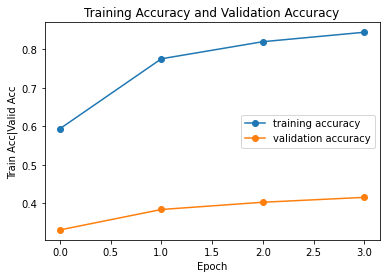

In [18]:
plt.figure()
plt.plot(model.history.history['accuracy'], marker='o', label='training accuracy')
plt.plot(model.history.history['val_accuracy'], marker='o', label='validation accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Train Acc|Valid Acc')
plt.show()

# Trying Model Improvements

## Viewing image
TODO

I do not know how to view images from the imagedatagenerator.
However, with an accuracy of greater than 1/29, it at least is not guessing the same value for all of them.

This and many other troubleshooting steps are based on the guide [here](https://www.kdnuggets.com/2017/08/37-reasons-neural-network-not-working.html)

## Disabling the datagen's shuffle feature
[Rumor has it](https://stackoverflow.com/questions/41695844/keras-showing-images-from-data-generator) from Gerry P., this is used "to maintain a correlation between the file and the associated prediction."

#### Training Data

In [28]:
train_data = data_generator(image_size = [80,80],
                            path = 'data/grassnoted split/asl_alphabet_train',
                            shuf = False
                           )
train_data


Found 42630 images belonging to 29 classes.


#### Validation Data

In [29]:
validation_data = data_generator(image_size = [80,80], 
                                 path = 'data/grassnoted split/asl_alphabet_validation',
                                 shuf = False
                                )
validation_data


Found 18270 images belonging to 29 classes.


#### Test Data

In [30]:
test_data = data_generator(image_size = [80,80],
                           path = 'data/grassnoted split/asl_alphabet_test',
                           shuf = False
                          )
test_data


Found 26100 images belonging to 29 classes.


#### Compiling Model

In [31]:
model.compile(loss = 'categorical_crossentropy', #loss function
                  optimizer = 'Adam',
                  metrics = ['accuracy']) #value to maximize

#### Fitting Model

In [32]:
model.fit_generator(train_data, validation_data = validation_data, steps_per_epoch = step_size_train, epochs = 4, verbose = 1)

C:\Users\h\.conda\envs\deeplearningcopy\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
533/533 [==============================] - 205s 376ms/step - loss: 1.2749 - accuracy: 0.6604 - val_loss: 3.7137 - val_accuracy: 0.2925
Epoch 2/4
533/533 [==============================] - 190s 357ms/step - loss: 1.1664 - accuracy: 0.6588 - val_loss: 3.5937 - val_accuracy: 0.3351
Epoch 3/4
533/533 [==============================] - 184s 344ms/step - loss: 1.1234 - accuracy: 0.6880 - val_loss: 3.3541 - val_accuracy: 0.3335
Epoch 4/4
533/533 [==============================] - 193s 362ms/step - loss: 1.1090 - accuracy: 0.6847 - val_loss: 4.2103 - val_accuracy: 0.3124


#### Plotting Model Progress

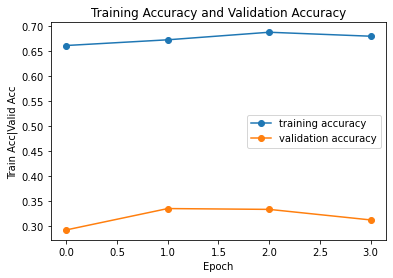

In [33]:
plt.figure()
plt.plot(model.history.history['accuracy'], marker='o', label='training accuracy')
plt.plot(model.history.history['val_accuracy'], marker='o', label='validation accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Train Acc|Valid Acc')
plt.show()

This appears to be less effective for both training and validation accuracies.
Returing to shuffle = True going forward.

## Perhaps that warning when importing MobileNetV2 is actually not all bark and no bite

As the input images are 200x200, it's possible to import and use images that are larger than 80x80. A limiting factor will be found if my kernel crashes.

Image shapes it prefers are \[96, 128, 160, 192, 224\] 

#### Training Data

In [38]:
train_data = data_generator(image_size = [96,96],
                            path = 'data/grassnoted split/asl_alphabet_train',
                           )
train_data


Found 42630 images belonging to 29 classes.


#### Validation Data

In [39]:
validation_data = data_generator(image_size = [96,96], 
                                 path = 'data/grassnoted split/asl_alphabet_validation',
                                )
validation_data


Found 18270 images belonging to 29 classes.


#### Test Data

In [40]:
test_data = data_generator(image_size = [96,96],
                           path = 'data/grassnoted split/asl_alphabet_test',
                          )
test_data


Found 26100 images belonging to 29 classes.


#### Creating Model

Importing MobileNetV2 for use in transfer learning.

In [46]:
experienced_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = (96,96,3))
#input shape minimum is 32x32
#this warning is all bark and no bite

Defining an untrained neural network to attach to the end of MobileNetV2 in order to make predictions in our current problem space.

In [47]:
# Assign the output of this base_model to a variable:
base_model_out = experienced_model.output



# Add a pooling layer:
base_model_out = GlobalAveragePooling2D()(base_model_out)

# using a softmax base_model_out activation function:
preds = Dense(29, activation='softmax')(base_model_out)




# Instantiate our final model, where we specify what are the inputs and 
# the outputs will look like
model = Model(inputs = experienced_model.input, 
              outputs = preds)

We can find the number of nodes in the topless MobileNetV2 by looking at the index of the pooling layer. These should be locked in order to preserve their weights.

In [48]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_4
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

We can see that layer 154 is where our added layers begin. We will lock all layers above 154 and make them untrainable.

In [49]:
for layer in model.layers[:154]:
    layer.trainable=False
    
for layer in model.layers[154:]:
    print(layer.name)
    layer.trainable=True

global_average_pooling2d_2
dense_2


In [50]:
train_data.batch_size

80

In [51]:
step_size_train = train_data.n//train_data.batch_size + 1

# 'train_data.n' = 60,900 images
# 'train_generator.batch_size' = 80 images per batch
# 'step_size_train' = 762  (!needs to be int)
step_size_train

533

#### Compiling Model

In [52]:
model.compile(loss = 'categorical_crossentropy', #loss function
                  optimizer = 'Adam',
                  metrics = ['accuracy']) #value to maximize

#### Fitting Model

In [53]:
model.fit_generator(train_data, validation_data = validation_data, steps_per_epoch = step_size_train, epochs = 4, verbose = 1)

C:\Users\h\.conda\envs\deeplearningcopy\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
533/533 [==============================] - 235s 436ms/step - loss: 2.0651 - accuracy: 0.4765 - val_loss: 2.4204 - val_accuracy: 0.3607
Epoch 2/4
533/533 [==============================] - 228s 429ms/step - loss: 0.7844 - accuracy: 0.8083 - val_loss: 2.3251 - val_accuracy: 0.4227
Epoch 3/4
533/533 [==============================] - 242s 454ms/step - loss: 0.5527 - accuracy: 0.8640 - val_loss: 2.3205 - val_accuracy: 0.4635
Epoch 4/4
533/533 [==============================] - 240s 450ms/step - loss: 0.4570 - accuracy: 0.8838 - val_loss: 2.3363 - val_accuracy: 0.4838


#### Plotting Model Progress

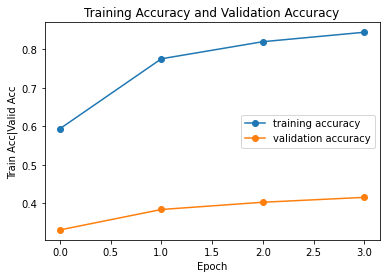

In [18]:
plt.figure()
plt.plot(model.history.history['accuracy'], marker='o', label='training accuracy')
plt.plot(model.history.history['val_accuracy'], marker='o', label='validation accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Train Acc|Valid Acc')
plt.show()

This added around 40s to each epoch, and does not look much different than the baseline graph.

## Adding dense layers to the untrained side of the neural network
I have no idea why I just noticed this, but the section of the neural network that is meant to be trainable has just one dense layer, the prediction output. Adding a few more dense layers in order to improve training with the given targets.

#### Training Data

In [5]:
train_data = data_generator(image_size = [80,80],
                            path = 'data/grassnoted split/asl_alphabet_train',
                           )
train_data


Found 42630 images belonging to 29 classes.


#### Validation Data

In [6]:
validation_data = data_generator(image_size = [80,80], 
                                 path = 'data/grassnoted split/asl_alphabet_validation',
                                )
validation_data


Found 18270 images belonging to 29 classes.


#### Test Data

In [7]:
test_data = data_generator(image_size = [80,80],
                           path = 'data/grassnoted split/asl_alphabet_test',
                          )
test_data


Found 26100 images belonging to 29 classes.


#### Creating Model

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Importing MobileNetV2 for use in transfer learning.

In [9]:
experienced_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = (80,80,3))
#input shape minimum is 32x32
#this warning is all bark and no bite

Defining an untrained neural network to attach to the end of MobileNetV2 in order to make predictions in our current problem space.

In [10]:
# Assign the output of this base_model to a variable:
base_model_out = experienced_model.output



# Add a pooling layer:
base_model_out = GlobalAveragePooling2D()(base_model_out)

# Add 3 dense layers so that the model can learn aspects of our new dataset 
# and classify for better results.
base_model_out = Dense(243, activation='relu')(base_model_out) 
base_model_out = Dense(243, activation='relu')(base_model_out)
base_model_out = Dense(81, activation='relu')(base_model_out)

# using a softmax base_model_out activation function:
preds = Dense(29, activation='softmax')(base_model_out)




# Instantiate our final model, where we specify what are the inputs and 
# the outputs will look like
model = Model(inputs = experienced_model.input, 
              outputs = preds)

We can find the number of nodes in the topless MobileNetV2 by looking at the index of the pooling layer. These should be locked in order to preserve their weights.

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

We can see that layer 154 is where our added layers begin. We will lock all layers above 154 and make them untrainable.

In [12]:
for layer in model.layers[:154]:
    layer.trainable=False
    
for layer in model.layers[154:]:
    print(layer.name)
    layer.trainable=True

global_average_pooling2d
dense
dense_1
dense_2
dense_3


#### Compiling Model

In [15]:
model.compile(loss = 'categorical_crossentropy', #loss function
                  optimizer = 'Adam',
                  metrics = ['accuracy']) #value to maximize

#### Fitting Model

In [13]:
train_data.batch_size

80

In [14]:
step_size_train = train_data.n//train_data.batch_size + 1

# 'train_data.n' = 60,900 images
# 'train_generator.batch_size' = 80 images per batch
# 'step_size_train' = 762  (!needs to be int)
step_size_train

533

In [16]:
model.fit_generator(train_data, validation_data = validation_data, steps_per_epoch = step_size_train, epochs = 4, verbose = 1)

C:\Users\h\.conda\envs\deeplearningcopy\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
533/533 [==============================] - 182s 335ms/step - loss: 1.9353 - accuracy: 0.4259 - val_loss: 2.3210 - val_accuracy: 0.3550
Epoch 2/4
533/533 [==============================] - 180s 337ms/step - loss: 0.6844 - accuracy: 0.7691 - val_loss: 2.4066 - val_accuracy: 0.3996
Epoch 3/4
533/533 [==============================] - 180s 338ms/step - loss: 0.5024 - accuracy: 0.8279 - val_loss: 2.4265 - val_accuracy: 0.4195
Epoch 4/4
533/533 [==============================] - 182s 341ms/step - loss: 0.4268 - accuracy: 0.8519 - val_loss: 2.5719 - val_accuracy: 0.4237


#### Plotting Model Progress

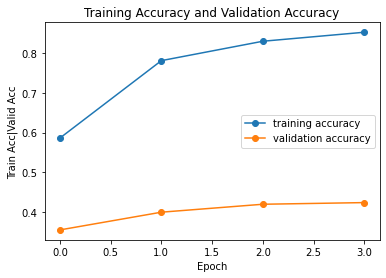

In [18]:
plt.figure()
plt.plot(model.history.history['accuracy'], marker='o', label='training accuracy')
plt.plot(model.history.history['val_accuracy'], marker='o', label='validation accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Train Acc|Valid Acc')
plt.show()

This model has similar results to the baseline. It seems like adding those dense layers should do something, so I may keep them going forward.

## Optimizing hyperparameters via grid search

### Defining grid search components

Homemade grid search, as the sklearn wrapper does not work with our current data input/output.

This generator works with square images only.

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import numpy
import pandas as pd

In [20]:
def data_generator(image_size, path, preprocess_func=None, split_off_for_val=0.0,
                   split_segment = None, shuf = True, bat_size = 80):
    
    this_datagen = ImageDataGenerator(preprocessing_function = preprocess_func, validation_split = split_off_for_val)
    #  note: ImageDataGenerator does not appear to have a parameter for random seeds. Be wary of train/val overlap
    #  note: train/val/test split does not currently work
    this_generator = this_datagen.flow_from_directory(path, 
                                                     target_size=image_size,
                                                     subset = split_segment, #  None|'training'|'validation'
                                                     color_mode='rgb',
                                                     batch_size= bat_size,
                                                     class_mode='categorical',
                                                     shuffle=shuf)
    
    return this_generator

In [21]:
def data_importer(im_side_len = 80, batch_size = 80):
    
    train_data = data_generator(image_size = [im_side_len, im_side_len],
                                path = 'data/grassnoted split/asl_alphabet_train',
                                bat_size = batch_size
                               )
    validation_data = data_generator(image_size = [im_side_len, im_side_len],
                                     path = 'data/grassnoted split/asl_alphabet_validation',
                                     bat_size = batch_size
                                    )
    test_data = data_generator(image_size = [im_side_len, im_side_len],
                               path = 'data/grassnoted split/asl_alphabet_test',
                               bat_size = batch_size
                              )
    
    return train_data, validation_data, test_data



In [22]:
def model_maker(im_side_len = 80):
    
    #assembling baseline model with three added dense layers (see above)
    # note: these layers are given different names by the system (i.e. the first is dense_4)
    #       but this does not seem to cause structural difference between models
    
    #transfer learning from experienced model
    experienced_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = (im_side_len,im_side_len,3))
    
    # Assign the output of this base_model to a variable:
    base_model_out = experienced_model.output

    # Add a pooling layer:
    base_model_out = GlobalAveragePooling2D()(base_model_out)

    # Add 3 dense layers so that the model can learn aspects of our new dataset 
    # and classify for better results.
    base_model_out = Dense(243, activation='relu')(base_model_out) 
    base_model_out = Dense(243, activation='relu')(base_model_out)
    base_model_out = Dense(81, activation='relu')(base_model_out)

    # using a softmax base_model_out activation function:
    preds = Dense(29, activation='softmax')(base_model_out)


    # Instantiate our final model, where we specify what are the inputs and 
    # the outputs will look like
    model = Model(inputs = experienced_model.input, 
                  outputs = preds)

    
    #The layers from MobileNetV2 will not be trained
    for layer in model.layers[:154]:
        layer.trainable=False

    for layer in model.layers[154:]:
        print(layer.name)
        layer.trainable=True
        
    return model

In [23]:
def model_compiler(model, loss_func = 'categorical_crossentropy', optim_choice = 'Adam', value_to_max = ['accuracy']):
    
    model.compile(loss = loss_func, #loss function
                  optimizer = optim_choice,
                  metrics = value_to_max) #value to maximize
    compiled_model = model
    return compiled_model

In [24]:
def model_fitter(compiled_model, train_data, validation_data, epochs = 1):  
    
    #step size based on batch size
    step_size_train = train_data.n//train_data.batch_size + 1
    
    print(step_size_train)
    
    model = compiled_model
    
    model.fit_generator(generator = train_data,
                        validation_data = validation_data,
                        steps_per_epoch = step_size_train,
                        epochs = 1,
                        verbose = 1)
    
    training_accuracy = model.history.history['categorical_accuracy']
    validation_accuracy = model.history.history['val_categorical_accuracy']
    
    return training_accuracy, validation_accuracy

### test 0

In [35]:
train_data, validation_data, test_data = data_importer(im_side_len = 96)
model_a = model_maker(im_side_len = 96)
compiled_model_a = model_compiler(model = model_a)
model_fitter(compiled_model = compiled_model_a, train_data = train_data, validation_data = validation_data)

Found 42630 images belonging to 29 classes.
Found 18270 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
global_average_pooling2d_6
dense_24
dense_25
dense_26
dense_27
533 <class 'int'>
533/533 [==============================] - 224s 415ms/step - loss: 1.7290 - accuracy: 0.4818 - val_loss: 2.3643 - val_accuracy: 0.4377


([0.6625146865844727], [0.4377121031284332])

In [36]:
a = [[0,0,{}]]
a.append([1,1,{'param1' : 1}])
a = np.array(a)
pd.DataFrame(a, columns = ['a', 'b','c'])

,a,b,c
0,0,0,{}
1,1,1,{'param1': 1}


### Defining the grid search

In [11]:
#input parameters to search through as lists
def grid_search(batch_sizes, image_sizes, loss_funcs, optims, values_to_max, epochs):
    a = []
    for i in batch_sizes:
        for j in image_sizes:
            train_data, validation_data, test_data = data_importer(batch_size = i, im_side_len = j)
            model = model_maker(im_side_len = j)
            for k in loss_funcs:
                print(k)
                for l in optims:
                    print(l)
                    for m in values_to_max:
                        print(m)
                        compiled_model = model_compiler(loss_func = k, optim_choice = l, value_to_max = m, model = model)
                        for n in epochs:
                            print(n)
                            train_acc, valid_acc = model_fitter(epochs = n,compiled_model = compiled_model, train_data = train_data, validation_data = validation_data)
                            
                            param_str = f'batch size : {i}\n image size {j} \n loss function {k} \n optimizer {l} \n value to maximize {m} \n epochs {n}'

                            a.append([train_acc[0], valid_acc[0], param_str])
    return a
            

In [14]:
test_1 = grid_search(batch_sizes = [40], 
                        image_sizes = [40, 60], 
                        loss_funcs = ['categorical_crossentropy'], 
                        optims = ['Adam'], 
                        values_to_max = ['accuracy'], 
                        epochs = [1])

Found 42630 images belonging to 29 classes.
Found 18270 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
global_average_pooling2d_2
dense_8
dense_9
dense_10
dense_11
categorical_crossentropy
Adam
accuracy
1
1066 <class 'int'>


C:\Users\h\.conda\envs\deeplearningcopy\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1066/1066 [==============================] - 155s 141ms/step - loss: 1.9241 - accuracy: 0.4129 - val_loss: 2.6722 - val_accuracy: 0.2836
Found 42630 images belonging to 29 classes.
Found 18270 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
global_average_pooling2d_3
dense_12
dense_13
dense_14
dense_15
categorical_crossentropy
Adam
accuracy
1
1066 <class 'int'>
1066/1066 [==============================] - 154s 139ms/step - loss: 1.6717 - accuracy: 0.4832 - val_loss: 2.6939 - val_accuracy: 0.3037


In [20]:
test_1_df = pd.DataFrame(test_1, columns = ['train_acc', 'valid_acc', 'param_str'])


In [21]:
print(test_1_df.iloc[0,2])

batch size : 40
 image size 40 
 loss function categorical_crossentropy 
 optimizer Adam 
 value to maximize accuracy 
 epochs 1


### test 2

Performing a larger grid search with 3 epochs and, due to time constraints, one small batch size, one small image size, and hyperparameters chosen from research rather than every available combination of options.

**Optimizer**

**Loss function** is tied in with the choice of activation function. For this multi-class-classification problem, softmax is being used as a final activation function. According to [this blog post](https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/), this should be paired with a categorical-crossentropy function. As the classification task does not use a sparse matrix, sparse_categorical_crossentropy will not be used as a loss function.

**Optimization Metric** lets the network know how well it's doing. Having multiple options here results in multiple different metrics being returned, which makes comparison difficult. In this particular task, classification with classes in the tens, the metric of choice will be categorical_accuracy. Find out more [in this post post](https://neptune.ai/blog/keras-metrics).

In [53]:
test_2 = grid_search(batch_sizes = [60], 
                        image_sizes = [96], #  original train images are 200x200 but kernel may crash
                        loss_funcs = ['categorical_crossentropy'], 
                        optims = ['SGD', 'RMSprop', 'Adadelta', 'Adam', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl'], 
                        values_to_max = ['categorical_accuracy'], 
                        epochs = [4])

Found 42630 images belonging to 29 classes.
Found 18270 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
global_average_pooling2d_13
dense_49
dense_50
dense_51
dense_52
categorical_crossentropy
SGD
categorical_accuracy
4
711
711/711 [==============================] - 239s 331ms/step - loss: 2.7400 - categorical_accuracy: 0.2397 - val_loss: 2.8192 - val_categorical_accuracy: 0.2209
RMSprop
categorical_accuracy
4
711
711/711 [==============================] - 249s 345ms/step - loss: 1.4407 - categorical_accuracy: 0.5536 - val_loss: 2.7043 - val_categorical_accuracy: 0.4172
Adadelta
categorical_accuracy
4
711
711/711 [==============================] - 252s 350ms/step - loss: 0.4868 - categorical_accuracy: 0.8331 - val_loss: 2.5105 - val_categorical_accuracy: 0.4566
Adam
categorical_accuracy
4
711
711/711 [==============================] - 265s 365ms/step - loss: 0.4231 - categorical_accuracy: 0.8509 - val_loss: 2.6641 - val_categorical_accuracy: 0.4701
Adagrad
c

In [54]:
test_2_df = pd.DataFrame(test_2,
             columns = ['train_acc', 'valid_acc', 'param_str'])
test_2_df.to_csv('data/test_2.csv')

In [58]:
test_2_df.head(10)

,train_acc,valid_acc,param_str
0,0.375557,0.220909,batch size : 60\n image size 96 \n loss functi...
1,0.665588,0.417241,batch size : 60\n image size 96 \n loss functi...
2,0.850317,0.456596,batch size : 60\n image size 96 \n loss functi...
3,0.867347,0.470060,batch size : 60\n image size 96 \n loss functi...
4,0.941356,0.526546,batch size : 60\n image size 96 \n loss functi...
5,0.937040,0.534921,batch size : 60\n image size 96 \n loss functi...
6,0.918836,0.509633,batch size : 60\n image size 96 \n loss functi...
7,0.033404,0.034483,batch size : 60\n image size 96 \n loss functi...


In [ ]:
#test_2_df = pd.read_csv('data/test_2.csv')

After removing hyperparameters in the loss function and metric categories that caused errors, I ended up just testing optimizers. This means the results will lack in context quite a lot. 
For the sake of time, the optimizer with the highest validation accuracy given the other hyperparameters will be used.

In [62]:
print('Highest validation accuracy among given options:', test_2_df.iloc[5,1], test_2_df.iloc[5,2])

Highest validation accuracy among given options: 0.5349206328392029 batch size : 60
 image size 96 
 loss function categorical_crossentropy 
 optimizer Adamax 
 value to maximize categorical_accuracy 
 epochs 4


By my current understanding, the most important hyperparameter in Adamax is the learning rate. This may be best tweaked further down the line.

### test 3

In this test, a variety of batch sizes will be considered.

In [71]:
test_3 = grid_search(batch_sizes = [10, 40, 60, 90], 
                        image_sizes = [96], #  original train images are 200x200 but kernel may crash
                        loss_funcs = ['categorical_crossentropy'], 
                        optims = ['Adamax'], 
                        values_to_max = ['categorical_accuracy'], 
                        epochs = [4])

Found 42630 images belonging to 29 classes.
Found 18270 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
global_average_pooling2d_16
dense_61
dense_62
dense_63
dense_64
categorical_crossentropy
Adamax
categorical_accuracy
4
4264
4264/4264 [==============================] - 336s 78ms/step - loss: 1.6799 - categorical_accuracy: 0.4981 - val_loss: 2.3575 - val_categorical_accuracy: 0.4278
Found 42630 images belonging to 29 classes.
Found 18270 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
global_average_pooling2d_17
dense_65
dense_66
dense_67
dense_68
categorical_crossentropy
Adamax
categorical_accuracy
4
1066
1066/1066 [==============================] - 274s 254ms/step - loss: 1.9228 - categorical_accuracy: 0.4429 - val_loss: 2.3953 - val_categorical_accuracy: 0.3806
Found 42630 images belonging to 29 classes.
Found 18270 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
global_average_pooling2d_18
dense_6

In [74]:
test_3_df = pd.DataFrame(test_3,
             columns = ['train_acc', 'valid_acc', 'param_str'])
test_3_df.to_csv('data/test_3.csv')

In [75]:
test_3_df.head(10)

,train_acc,valid_acc,param_str
0,0.666268,0.427750,batch size : 10\n image size 96 \n loss functi...
1,0.616749,0.380624,batch size : 40\n image size 96 \n loss functi...
2,0.607014,0.393924,batch size : 60\n image size 96 \n loss functi...
3,0.577082,0.374548,batch size : 90\n image size 96 \n loss functi...


Batch size 10 seems to have generated a warning, so I will go with the runner-up, batch size 60.

### test 4

In this test, a variety of image sizes will be considered.

All images will be square.

Most will be selected as they are more compatible with MobileNetV2.

In [76]:
test_4 = grid_search(batch_sizes = [60], 
                        image_sizes = [60, 96, 128, 160, 192], #  original train images are 200x200 but kernel may crash
                        loss_funcs = ['categorical_crossentropy'], 
                        optims = ['Adamax'], 
                        values_to_max = ['categorical_accuracy'], 
                        epochs = [4])

Found 42630 images belonging to 29 classes.
Found 18270 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
global_average_pooling2d_20
dense_77
dense_78
dense_79
dense_80
categorical_crossentropy
Adamax
categorical_accuracy
4
711


C:\Users\h\.conda\envs\deeplearningcopy\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


711/711 [==============================] - 143s 196ms/step - loss: 1.9260 - categorical_accuracy: 0.4307 - val_loss: 2.6533 - val_categorical_accuracy: 0.3192
Found 42630 images belonging to 29 classes.
Found 18270 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
global_average_pooling2d_21
dense_81
dense_82
dense_83
dense_84
categorical_crossentropy
Adamax
categorical_accuracy
4
711
711/711 [==============================] - 237s 329ms/step - loss: 1.9791 - categorical_accuracy: 0.4370 - val_loss: 2.4684 - val_categorical_accuracy: 0.3839
Found 42630 images belonging to 29 classes.
Found 18270 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.
9412608/9406464 [==============================] - 4s 0us/step
global_average_pooling2d_22
dense_85
dense_86
dense_87
dense_88
categorical_crossentropy
Adamax
categorical_accuracy
4
711
711/711 [==============================] - 404s 564ms/step - loss: 1.9164 - categorical_accuracy: 0.4689 - va

In [77]:
test_4_df = pd.DataFrame(test_4,
             columns = ['train_acc', 'valid_acc', 'param_str'])
test_4_df.to_csv('data/test_4.csv')

In [78]:
test_4_df.head(10)

,train_acc,valid_acc,param_str
0,0.559442,0.319212,batch size : 60\n image size 60 \n loss functi...
1,0.607131,0.383853,batch size : 60\n image size 96 \n loss functi...
2,0.642834,0.448823,batch size : 60\n image size 128 \n loss funct...
3,0.818625,0.557362,batch size : 60\n image size 160 \n loss funct...
4,0.672038,0.473946,batch size : 60\n image size 192 \n loss funct...


It appears that 160x160 images performed best in this test. 

### Test 5

In this test, a variety of epochs will be tested.

#### Training Data

In [23]:
train_data = data_generator(image_size = [160,160],
                            bat_size = 60,
                            path = 'data/grassnoted split/asl_alphabet_train',
                           )
train_data


Found 42630 images belonging to 29 classes.


#### Validation Data

In [24]:
validation_data = data_generator(image_size = [160,160],
                                 bat_size = 60,
                                 path = 'data/grassnoted split/asl_alphabet_validation',
                                )
validation_data


Found 18270 images belonging to 29 classes.


#### Test Data

In [25]:
test_data = data_generator(image_size = [160,160],
                           bat_size = 60,
                           path = 'data/grassnoted split/asl_alphabet_test',
                          )
test_data


Found 26100 images belonging to 29 classes.


#### Creating Model

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Importing MobileNetV2 for use in transfer learning.

In [17]:
experienced_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = (160,160,3))
#input shape minimum is 32x32
#this warning is all bark and no bite

Defining an untrained neural network to attach to the end of MobileNetV2 in order to make predictions in our current problem space.

In [18]:
# Assign the output of this base_model to a variable:
base_model_out = experienced_model.output



# Add a pooling layer:
base_model_out = GlobalAveragePooling2D()(base_model_out)

# Add 3 dense layers so that the model can learn aspects of our new dataset 
# and classify for better results.
base_model_out = Dense(243, activation='relu')(base_model_out) 
base_model_out = Dense(243, activation='relu')(base_model_out)
base_model_out = Dense(81, activation='relu')(base_model_out)

# using a softmax base_model_out activation function:
preds = Dense(29, activation='softmax')(base_model_out)




# Instantiate our final model, where we specify what are the inputs and 
# the outputs will look like
model = Model(inputs = experienced_model.input, 
              outputs = preds)

We can find the number of nodes in the topless MobileNetV2 by looking at the index of the pooling layer. These should be locked in order to preserve their weights.

In [19]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

We can see that layer 154 is where our added layers begin. We will lock all layers above 154 and make them untrainable.

In [20]:
for layer in model.layers[:154]:
    layer.trainable=False
    
for layer in model.layers[154:]:
    print(layer.name)
    layer.trainable=True

global_average_pooling2d
dense
dense_1
dense_2
dense_3


#### Compiling Model

In [30]:
model.compile(loss = 'categorical_crossentropy', #loss function
                  optimizer = 'Adamax',
                  metrics = ['categorical_accuracy']) #value to maximize

#### Fitting Model

In [27]:
train_data.batch_size

60

In [28]:
step_size_train = train_data.n//train_data.batch_size + 1

# 'train_data.n' = 60,900 images
# 'train_generator.batch_size' = 80 images per batch
# 'step_size_train' = 762  (!needs to be int)
step_size_train

711

In [31]:
model.fit_generator(train_data, validation_data = validation_data, steps_per_epoch = step_size_train, epochs = 6, verbose = 1)

Epoch 1/6
711/711 [==============================] - 616s 862ms/step - loss: 0.0594 - categorical_accuracy: 0.9827 - val_loss: 2.3626 - val_categorical_accuracy: 0.6216
Epoch 2/6
711/711 [==============================] - 635s 894ms/step - loss: 0.0340 - categorical_accuracy: 0.9896 - val_loss: 2.3131 - val_categorical_accuracy: 0.6159
Epoch 3/6
711/711 [==============================] - 638s 897ms/step - loss: 0.0271 - categorical_accuracy: 0.9912 - val_loss: 2.5822 - val_categorical_accuracy: 0.5964
Epoch 4/6
711/711 [==============================] - 641s 902ms/step - loss: 0.0264 - categorical_accuracy: 0.9916 - val_loss: 2.4974 - val_categorical_accuracy: 0.6247
Epoch 5/6
711/711 [==============================] - 647s 910ms/step - loss: 0.0226 - categorical_accuracy: 0.9936 - val_loss: 2.5024 - val_categorical_accuracy: 0.6313
Epoch 6/6
711/711 [==============================] - 649s 914ms/step - loss: 0.0191 - categorical_accuracy: 0.9938 - val_loss: 2.5952 - val_categorical_acc

#### Plotting Model Progress

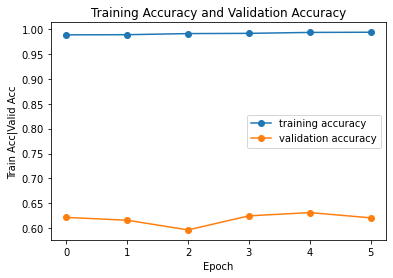

In [37]:
plt.figure()
plt.plot(model.history.history['categorical_accuracy'], marker='o', label='training accuracy')
plt.plot(model.history.history['val_categorical_accuracy'], marker='o', label='validation accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.xticks(ticks = range(0,6))
plt.ylabel('Train Acc|Valid Acc')
plt.show()

This model has similar results to the baseline. It seems like adding those dense layers should do something, so I may keep them going forward.

# Generating New Baseline: Model 5

Using features considered above, a new model will be generated.

#### Training Data

In [26]:
train_data = data_generator(image_size = [160,160],
                            bat_size = 60,
                            path = 'data/grassnoted split/asl_alphabet_train',
                           )
train_data


Found 42630 images belonging to 29 classes.


#### Validation Data

In [27]:
validation_data = data_generator(image_size = [160,160],
                                 bat_size = 60,
                                 path = 'data/grassnoted split/asl_alphabet_validation',
                                )
validation_data


Found 18270 images belonging to 29 classes.


#### Test Data

In [28]:
test_data = data_generator(image_size = [160,160],
                           bat_size = 60,
                           path = 'data/grassnoted split/asl_alphabet_test',
                          )
test_data


Found 26100 images belonging to 29 classes.


#### Creating Model

In [41]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Importing MobileNetV2 for use in transfer learning.

In [42]:
experienced_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = (160,160,3))
#input shape minimum is 32x32
#this warning is all bark and no bite

Defining an untrained neural network to attach to the end of MobileNetV2 in order to make predictions in our current problem space.

In [43]:
# Assign the output of this base_model to a variable:
base_model_out = experienced_model.output



# Add a pooling layer:
base_model_out = GlobalAveragePooling2D()(base_model_out)

# Add 3 dense layers so that the model can learn aspects of our new dataset 
# and classify for better results.
base_model_out = Dense(243, activation='relu')(base_model_out) 
base_model_out = Dense(243, activation='relu')(base_model_out)
base_model_out = Dense(81, activation='relu')(base_model_out)

# using a softmax base_model_out activation function:
preds = Dense(29, activation='softmax')(base_model_out)




# Instantiate our final model, where we specify what are the inputs and 
# the outputs will look like
model = Model(inputs = experienced_model.input, 
              outputs = preds)

We can find the number of nodes in the topless MobileNetV2 by looking at the index of the pooling layer. These should be locked in order to preserve their weights.

In [44]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_2
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

We can see that layer 154 is where our added layers begin. We will lock all layers above 154 and make them untrainable.

In [45]:
for layer in model.layers[:154]:
    layer.trainable=False
    
for layer in model.layers[154:]:
    print(layer.name)
    layer.trainable=True

global_average_pooling2d_1
dense_4
dense_5
dense_6
dense_7


#### Compiling Model

In [46]:
model.compile(loss = 'categorical_crossentropy', #loss function
                  optimizer = 'Adamax',
                  metrics = ['categorical_accuracy']) #value to maximize

#### Fitting Model

In [47]:
train_data.batch_size

60

In [48]:
step_size_train = train_data.n//train_data.batch_size + 1

# 'train_data.n' = 60,900 images
# 'train_generator.batch_size' = 80 images per batch
# 'step_size_train' = 762  (!needs to be int)
step_size_train

711

In [49]:
model.fit_generator(train_data, validation_data = validation_data, steps_per_epoch = step_size_train, epochs = 4, verbose = 1)

Epoch 1/4
711/711 [==============================] - 628s 878ms/step - loss: 1.2890 - categorical_accuracy: 0.6623 - val_loss: 1.7502 - val_categorical_accuracy: 0.5443
Epoch 2/4
711/711 [==============================] - 649s 913ms/step - loss: 0.1950 - categorical_accuracy: 0.9430 - val_loss: 1.8650 - val_categorical_accuracy: 0.5782
Epoch 3/4
711/711 [==============================] - 654s 920ms/step - loss: 0.1145 - categorical_accuracy: 0.9655 - val_loss: 1.9211 - val_categorical_accuracy: 0.5828
Epoch 4/4
711/711 [==============================] - 625s 879ms/step - loss: 0.0812 - categorical_accuracy: 0.9750 - val_loss: 2.0723 - val_categorical_accuracy: 0.6003


#### Plotting Model Progress

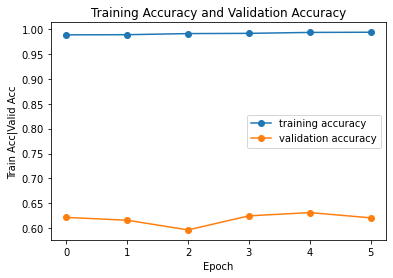

In [37]:
plt.figure()
plt.plot(model.history.history['categorical_accuracy'], marker='o', label='training accuracy')
plt.plot(model.history.history['val_categorical_accuracy'], marker='o', label='validation accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.xticks(ticks = range(0,6))
plt.ylabel('Train Acc|Valid Acc')
plt.show()

#### Generating Confusion Matrix

Using the stackoverflow answer [here](https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras).

In [41]:
test_steps_per_epoch = numpy.math.ceil(test_data.samples / test_data.batch_size)

prediction = model.predict_generator(test_data, steps = test_steps_per_epoch)
test_pred = prediction.argmax(axis=1)

test_true = test_data.classes


pd.DataFrame(confusion_matrix(test_true,test_pred))



C:\Users\h\.conda\envs\deeplearningcopy\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,10,34,18,14,16,31,30,33,23,7,...,49,32,46,7,33,154,117,26,10,61
1,6,28,29,10,17,38,31,21,16,6,...,52,39,43,11,29,153,118,22,6,54
2,13,33,25,15,8,29,32,33,16,4,...,55,40,47,10,21,142,111,28,7,60
3,13,32,24,10,12,33,30,20,28,4,...,52,37,28,11,23,165,121,24,5,67
4,11,32,16,11,17,28,24,27,21,9,...,52,35,38,7,16,153,125,30,5,59
5,9,24,16,12,12,28,30,24,17,7,...,51,32,38,13,32,162,130,20,5,58
6,7,32,29,10,15,36,35,33,17,10,...,42,38,40,8,28,179,108,27,2,50
7,5,26,23,17,12,35,21,25,22,8,...,47,45,39,8,32,176,99,27,4,52
8,9,27,21,14,12,33,28,36,18,12,...,37,31,25,13,25,170,116,29,7,73
9,9,28,14,11,14,38,32,34,30,7,...,40,46,35,10,27,157,120,24,7,57


<AxesSubplot:>

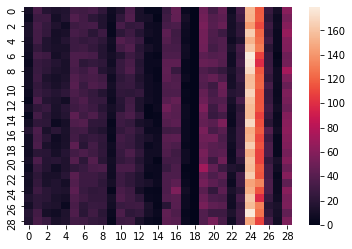

In [59]:
a = test_true.reshape(26100,1)
b = test_pred.reshape(26100,1)

sns.heatmap(pd.DataFrame(confusion_matrix(test_true,test_pred)))

In [53]:

from sklearn.metrics import classification_report

In [57]:

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())   


report = classification_report(true_classes, test_pred, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

           A       0.04      0.01      0.02       900
           B       0.03      0.03      0.03       900
           C       0.04      0.03      0.03       900
           D       0.03      0.01      0.02       900
           E       0.04      0.02      0.03       900
           F       0.03      0.03      0.03       900
           G       0.04      0.04      0.04       900
           H       0.03      0.03      0.03       900
           I       0.03      0.02      0.02       900
           J       0.03      0.01      0.01       900
           K       0.03      0.03      0.03       900
           L       0.02      0.02      0.02       900
           M       0.03      0.02      0.02       900
           N       0.01      0.00      0.00       900
           O       0.02      0.00      0.01       900
           P       0.04      0.04      0.04       900
           Q       0.03      0.03      0.03       900
           R       0.03    

These metrics seem to indicate that the model prefers to predict y and z more often than it should.

### Making Interactive Demo For Model

In [7]:
import numpy as np
import cv2 as cv
import sys
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


In [12]:


## function to make predictions

#inputs a keras model and the filepath for a photo of a hand relative to the local directory
#photo must be RGB
#returns an array that sums to 1 with prediction weights for each class the model can detect.
def load_and_predict_photo(model, path):
    #loading photo
    photo = image.load_img(path,
                           grayscale=False,
                           color_mode="rgb",
                           target_size=model.input_shape[1:3],
                           interpolation="nearest")
    input_arr = image.img_to_array(photo)
    input_arr = np.array([input_arr])  #this model predicts based on batches. Making solo batch.
    predictions = model.predict(input_arr)
    return predictions


In [13]:
def preds_to_letter(prediction_series):
    strongest_guess= prediction_series.argmax()
    labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']
    return labels[strongest_guess]

In [4]:

## importing trained model
print('importing model')
model = load_model("model_5") #  loads a model from this folder



importing model


In [9]:

## video feed
# press s to snap an image
# press q to quit

vid_feed = cv.VideoCapture(0) #  goes with the first camera it can find in this device

#  creates a new window titled by the input string
cv.namedWindow('test')
print('video feed launching')
while True:
    success_bool, frame = vid_feed.read()
    
    if (not success_bool):
        print('error reading video feed')
        break        
    
    #cropping frame
    frame = frame[150:310, 90:250] #  [ V , > ]
    
    cv.imshow('test', frame)
    # cv.waitKey(1) waits 1ms for a key press,
    # returning that pressed key as a string
    k = cv.waitKey(1) 

    ## press 's' to save the image and make a prediction on it
    if k == ord("s"):
        cv.imwrite('data/opencv_images/test_capture.png', frame)
        print('identifying sign')
        prediction_array = load_and_predict_photo(model = model, path = 'data/opencv_images/test_capture.png')
        prediction = preds_to_letter(prediction_array)
        print(prediction)
    elif k == ord("q"):
        print('quit')
        break
    else:
        pass

#closes all windows opened by cvq
cv.destroyAllWindows()    
    

video feed launching
identifying sign
nothing
identifying sign
nothing
identifying sign
B
identifying sign
nothing
identifying sign
M
identifying sign
nothing
identifying sign
nothing
identifying sign
B
identifying sign
nothing
identifying sign
B
identifying sign
B
identifying sign
M
identifying sign
M
identifying sign
B
identifying sign
nothing
identifying sign
B
quit


## Trying Further Model Improvements

Now that the second demo day has passed, I will be taking more time to improve the model's capabilites. Hopefully, a model that correctly predicts letters somewhat consistently will be produced. After letter prediction, the next step seems to be the use of some form of autocorrect in order to correct missed letters (converting a misspelled word to its closest neighbor in levenshtein distance, maybe).

### Improving validation accuracy via data augmentation

By augmenting data, overfitting should be reduced. Train data, as well as all of the data, may be predicted less accurately, but the model should have more general functionality.

### Optimizing Hyperparameters via Keras Tuner

As it turns out, keras has its own ways of optimizing hyperparameters. This may be more effective than the grid search tactic I used above, which was based on a sklearn grid search. Not only is this built for keras, but it includes optimization of the neural net's structure as well.